In [ ]:
"""
Quelle: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset?resource=download
Hier haben wir einen Datensatz von Kaggle über Gesichter Geschlechtererkennung
"""
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d cashutosh/gender-classification-dataset

 98% 265M/269M [00:01<00:00, 244MB/s]
100% 269M/269M [00:01<00:00, 199MB/s]


In [ ]:
import zipfile
import os
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt
"""
Hier haben wir alle relevanten imports
"""

In [ ]:
"""
Quelle: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset?resource=download
Entpacken von dem Datensatz-Zip-Datei
"""
try:
    with zipfile.ZipFile("/content/gender-classification-dataset.zip", "r") as zip_ref:
        zip_ref.extractall("/content")
except FileNotFoundError:
    print("Datei wurde nicht gefunden")

In [ ]:
"""
Quelle: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset?resource=download
Objektorientierung: Eigene Klasse für die Datensätze
"""
class GenderDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = [os.path.join(gender_dir, img_file)
                       for gender in ["male", "female"]
                       for gender_dir in [os.path.join(directory, gender)]
                       for img_file in os.listdir(gender_dir)
                       if re.match(r'.*\.jpg$', img_file)]
        self.labels = [label for gender in ["male", "female"]
                       for label, gender_dir in enumerate([os.path.join(directory, gender)])
                       for img_file in os.listdir(gender_dir)
                       if re.match(r'.*\.jpg$', img_file)]

        for label, gender in enumerate(["male", "female"]):
            gender_dir = os.path.join(directory, gender)
            for img_file in os.listdir(gender_dir):
                if img_file.endswith(".jpg"):
                    img_path = os.path.join(gender_dir, img_file)
                    self.images.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
"""
Visualisierung der Aufteilung der Datensätze
"""
def visualize_data_distribution(dataset):
    label_to_str = lambda x: 'Männlich' if x == 0 else 'Weiblich'
    labels = [label_to_str(label) for _, label in dataset]
    label_count = {label: labels.count(label) for label in set(labels)}

    sizes = [label_count['Männlich'], label_count['Weiblich']]
    colors = ['lightblue', 'lightcoral']
    explode = (0.1, 0)

    plt.pie(sizes, explode=explode, labels=list(label_count.keys()), colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')
    plt.title("Verteilung der Daten im Dataset")
    plt.show()

In [ ]:
"""
Quelle: https://www.youtube.com/watch?v=V_xro1bcAuA&t=43293s&ab_channel=freeCodeCamp.org
KI arbeiten mit Zahlen,
deshalb werden die Daten in Tensors umgewandelt.
"""

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

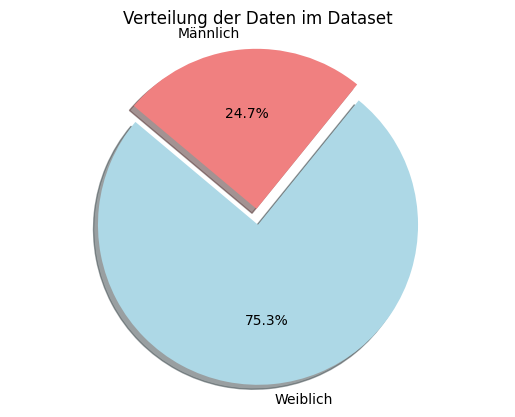

In [ ]:
"""
Quelle: https://www.youtube.com/watch?v=V_xro1bcAuA&t=43293s&ab_channel=freeCodeCamp.org
Visualisierung der Aufteilung der Datensätze (Training Datensatz)
"""
dataset = GenderDataset("/content/Training", transform)
visualize_data_distribution(dataset)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
"""
Quelle: https://stefanobosisio1.medium.com/a-reverse-engineer-approach-to-explain-attention-and-memory-88ca63dfd1f1
Das Künstliche Neuronales Netzwerk welches wir benutzen
"""
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Umformen für vollverbundene Schicht
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
"""
Quelle: https://www.youtube.com/watch?v=V_xro1bcAuA&t=43293s&ab_channel=freeCodeCamp.org
Treiningsablauf
Hier wird das Modell trainiert. Die Menge an Durchläufen kann man einstellen,
um das Ergebniss zu verbessern
"""
model_1 = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

for epoch in range(1):
    for images, labels in dataloader:
        # Forward-Pass
        outputs = model_1(images)
        loss = criterion(outputs, labels)

        # Backward und Optimieren
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

' \nNur auskommentieren wenn man weiter trainieren möchte\n\nfor epoch in range(1):\n    for images, labels in dataloader:\n        # Forward-Pass\n        outputs = model_1(images)\n        loss = criterion(outputs, labels)\n\n        # Backward und Optimieren\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n'

In [ ]:
"""
Hier laden wir unser Model was wir davon gespeichert haben, damit man einen
Lernfortschritt Verlust von über einer Stunde verhindert.
"""
drive.mount('/content/drive')

model_1 = SimpleCNN()
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

model_state = torch.load('/content/drive/My Drive/model_1.pth')

model_1.load_state_dict(model_state['model'])
optimizer.load_state_dict(model_state['optimizer'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
"""
Quelle: https://www.youtube.com/watch?v=V_xro1bcAuA&t=43293s&ab_channel=freeCodeCamp.org
Das Modell wird auf den Validations Datensatz ausgeführt und dabei auf die Korrektheit überprüft
"""
dataset = GenderDataset('/content/Validation', transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model_1.eval()
total = 0
correct = 0

with torch.no_grad():
    for images, labels in dataloader:
        outputs = model_1(images)
        _, guesses = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (guesses == labels).sum().item()

accuracy = 100 * correct / total
print(f'Korrektheit des Modells: {accuracy}%')

Accuracy of the model on the test images: 71.1176925057945%
